In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
import os
import random
from utils import *

In [2]:
images_folder_path = './Images/1'
images = load_images(images_folder_path)


kps, dess, pw_correspondences = pairwise_correspondences(images, ratio=0.6)


In [31]:
pw_homographies, pw_inliers, pw_outliers, matches = pairwise_ransac(pw_correspondences)


In [34]:
print(matches)

[(0, 2), (0, 8), (0, 12), (0, 13), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (2, 8), (2, 11), (2, 12), (2, 13), (3, 4), (3, 6), (3, 8), (3, 9), (4, 5), (4, 6), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (6, 8), (6, 9), (7, 10), (7, 11), (8, 9), (10, 11), (10, 13), (11, 13), (12, 13)]


In [9]:
params = np.array([0.82865851, 1.1214942,  0.62030894, 0.56486666, 0.97213219, 0.92651278,
 1.13550712, 1.19082724, 1.09366139, 1.17320495, 0.48601178, 0.37134116
, 1.02411499, 1.15568618, 0.78340414, 0.71302543, 1.00480737, 1.03986211
, 0.98142259, 0.97889921, 0.98045299, 0.83978737, 1.23645249, 1.33214113
, 1.0338313, 0.99820324, 1.04136166, 1.06079396, 1.18099636, 0.95383441
, 1.10072481, 1.14335522, 1.1544375, 0.80193776, 1.2767471, 1.3894025
, 1.40631704, 1.09682897, 0.89048555, 0.85612505, 0.98071733, 1.09788141
, 0.8887442, 0.85363571, 0.90215622, 0.72287903, 1.35493803, 1.50113505
, 0.45116154, 0.566151, 1.48982577, 1.69828609, 0.98692738, 0.99562689
, 0.86136423, 0.92040969, 0.65498974, 1.20708656, 0.37562365, 0.21390361])

In [22]:
homographies = np.empty(len(images), dtype=object)
for i in range(len(images)):
    K = np.array([[params[4*i], 0, 0], [0, params[4*i],0], [0, 0, 1]])
    theta = np.sqrt(params[4*i+1]**2 + params[4*i+2]**2 + params[4*i+3]**2)
    R = np.array([[0, -params[4*i+3], params[4*i+2]], [params[4*i+3], 0, -params[4*i+1]], [-params[4*i+2], params[4*i+1], 0]])
    R = np.eye(3) + np.sin(theta)/theta * R + (1-np.cos(theta))/(theta**2) * np.matmul(R, R)
    homographies[i] = np.matmul(K, R)

In [35]:
img = cv2.warpPerspective(images[0], pw_homographies[0][2], (images[1].shape[1], images[1].shape[0]))

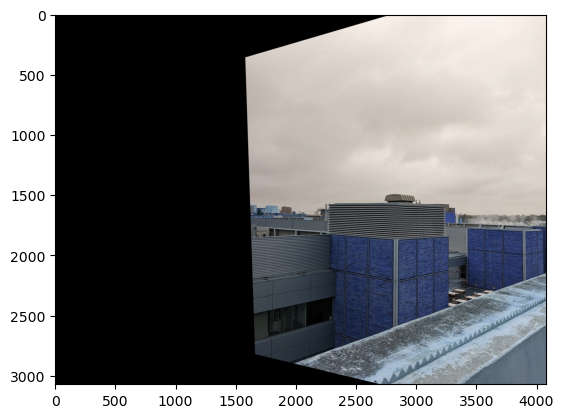

In [37]:
plt.imshow(img)
plt.show()


In [19]:
import scipy.optimize as opt

def sparsity_shape(pw_inliers, matches):
    num_residuals = 0
    num_params = 4*pw_inliers.shape[0]
    for match in matches:
        i,j = match
        num_residuals += 4 * len(pw_inliers[i][j])

    sparsity = np.zeros((num_residuals, num_params))
    for match in matches:
        i,j = match
        idx = 2*i*pw_inliers.shape[0]+2*j
        sparsity[idx:idx+4, 4*i:4*i+4] = np.ones((4,4))
        sparsity[idx:idx+4, 4*j:4*j+4] = np.ones((4,4))

    return sparsity

def jax_residual(params, pw_inliers, matches):
    num_residuals = 0
    error = 0

    for match in matches:
        i,j = match
        num_residuals += 4 * len(pw_inliers[i][j])

    residuals = np.zeros(num_residuals)
    for match in matches:
        i,j = match

        fi = params[4*i]
        fj = params[4*j]
        ri1 = params[4*i+1]
        ri2 = params[4*i+2]
        ri3 = params[4*i+3]
        rj1 = params[4*j+1]
        rj2 = params[4*j+2]
        rj3 = params[4*j+3]

        Ki = np.array([[fi, 0, 0], [0, fi, 0], [0, 0, 1]])
        Kj = np.array([[fj, 0, 0], [0, fj, 0], [0, 0, 1]])
        Ri = np.array([[0, -ri3, ri2], [ri3, 0, -ri1], [-ri2, ri1, 0]])           
        Rj = np.array([[0, -rj3, rj2], [rj3, 0, -rj1], [-rj2, rj1, 0]])

        thetai = np.sqrt(ri1**2 + ri2**2 + ri3**2)
        thetaj = np.sqrt(rj1**2 + rj2**2 + rj3**2)

        Ri = np.eye(3) + np.sin(thetai)/thetai * Ri + (1-np.cos(thetai))/(thetai**2) * np.matmul(Ri, Ri)
        Rj = np.eye(3) + np.sin(thetaj)/thetaj * Rj + (1-np.cos(thetaj))/(thetaj**2) * np.matmul(Rj, Rj)

        for correspondence in pw_inliers[i][j]:
            point1, point2 = correspondence

            pijk = np.matmul(Ki, np.matmul(Ri, np.matmul(Rj.T, np.matmul(np.linalg.inv(Kj), np.append(point2, 1)))))
            pijl = np.matmul(Kj, np.matmul(Rj, np.matmul(Ri.T, np.matmul(np.linalg.inv(Ki), np.append(point1, 1)))))

            residual1 = point1 - pijk[:-1] / pijk[-1]
            residual2 = point2 - pijl[:-1] / pijl[-1]

            error += np.sum(residual1**2) + np.sum(residual2**2)
            idx = 2*i*pw_inliers.shape[0]+2*j
            residuals[idx] = residual1[0]
            residuals[idx+1] = residual1[1]
            residuals[idx+2] = residual2[0]
            residuals[idx+3] = residual2[1]

    return residuals

def bundle_adjust_jax(pw_inliers, matches, images, max_iter = 100):
    params = np.ones(4*len(pw_inliers))
    for i in range(len(images)):
        params[4*i] = images[i].shape[1]
    result = opt.least_squares(jax_residual, params, jac_sparsity = sparsity_shape(pw_inliers, matches), args=(pw_inliers, matches), verbose = 2, max_nfev = max_iter)
    params = result.x

    return params

In [20]:

params = bundle_adjust_jax(pw_inliers, matches)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1054e+08                                    1.11e+11    
       1              4         9.2609e+07      1.79e+07       4.35e-02       5.69e+10    
       2              5         8.1275e+07      1.13e+07       1.62e-02       4.46e+10    
       3              6         7.3880e+07      7.39e+06       4.35e-02       2.78e+10    
       4              7         7.3246e+07      6.35e+05       8.71e-02       8.62e+10    
       5              8         7.0177e+07      3.07e+06       5.30e-03       7.47e+10    
       6              9         6.3283e+07      6.89e+06       1.33e-02       3.42e+10    
       7             10         6.0260e+07      3.02e+06       2.18e-02       3.23e+10    
       8             11         5.7613e+07      2.65e+06       2.18e-02       1.46e+10    
       9             12         5.5687e+07      1.93e+06       2.18e-02       2.88e+09    

In [21]:
print(params)
print(params.shape)
print(len(images))

[0.84413744 1.13825541 0.60656244 0.54441025 1.18581747 0.91688405
 1.13526304 1.20352346 1.02298253 1.18837028 0.47110419 0.35179996
 1.02031553 1.1640012  0.75026158 0.67781077 1.05273277 1.06707482
 0.92558303 0.91378889 0.72590099 0.80844889 1.25933714 1.37823862
 1.00134235 1.00870415 1.01385292 1.03453639 1.15257343 0.73674715
 1.33167366 1.48273538 1.36897936 1.10055796 0.86940943 0.83772014
 1.03429398 1.1062326  0.85950161 0.82428459 0.94581379 0.69779006
 1.36854927 1.53634892 0.72996373 0.47658741 1.54803588 1.80314335
 0.98391222 1.00798233 0.86136099 0.91531469 0.7020301  1.21965328
 0.36579787 0.20338309]
(56,)
14
